In [266]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [267]:
# Určení hodnoty parametru beta
BETA = 1

# Řešení 1D transportní úlohy

**1D úloha konvekce:**
\begin{align*}
     \frac{\partial u}{\partial t}+\beta\frac{\partial u}{\partial x}&=0,\:\:x\in\langle 0,2\pi\rangle,\:\:t\in\langle 0,1  \rangle,\\
    u(x,0)&=\sin(x)+\cos(x),\\
    u(0,t)&=u(2\pi,t),
\end{align*}
kde $\beta>0$ je koeficient konvekce.
Analytické řešení této úlohy je 
\begin{equation} u(x,t)=\sin(x-\beta t)+\cos(x-\beta t). \end{equation}

Použijeme NN s 5 skrytými vrstvami s aktivační funkcí $tanh()$ s 20 neurony v každé vrstvě.
Trénování provedeme na 1000 rovnoměrně rozložených bodech uvnitř oblasti $(-1,1)\times(0,1)$ a 150 bodech na hranici oblasti.
Trénování provedeme ve 5000 epochách.
Využijeme optimalizátor Adam s learning rate $5\cdot 10^{-3}$ v prvních 4900 epochách a optimalizátor LBFGS s learning rate $10^{-1}$, maximálním počtem iterací v optimalizačním kroku $20$ a update history size $10$ na posledních 100 epoch.
Testování provedeme na 10000 náhodně rozložených bodech vygenerovaných metodou LHS.

Proces definice, učení a testování neuronové sítě je rozdělen do několika kroků:

**Krok 1:**
Definujeme architekturu neuronové sítě.
Vytvoříme pomocné funkce:
- `generate_inner_train_data()` pro generování trénovacích bodů uvnitř oblasti,
- `generate_boundaries()` pro generování trénovacích bodů na hranici oblasti,
- `plot_boundaries()` pro vykreslení trénovacích bodů,
- `compute_derivatives_2d()` pro výpočet derivací,
- `exact_solution()` pro výpočet analytického řešení,
- `enerate_test_data_lhs()` pro vygenerování testovacích dat metodou LHS.

**Krok 2:**
Definujeme funkce pro výpočet ztráty a funkce closure pro použití optimalizátoru LBFGS:
- `compute_loss()` pro výpočet ztrátové funkce,
- `closure()` pro použití optimalizátoru LBFGS.

**Krok 3:**
Vygenerujeme trénovací data, inicializujeme model a optimalizátor Adam.

**Krok 4:**
Spustíme trénovací smyčku na 5000 epochách se změnou optimalizátoru na LBFGS po 4900 epochách.
Vykreslíme graf znázorňující závislost ztráty na počtu epoch.

**Krok 5:**
Vykreslíme aproximace řešení pomocí NN s využitím interpolace.
Vykreslíme řezy přesného a aproximovaného řešení v t=0,25; t=0,5; t=0,75.

**Krok 6:**
Výpočteme celkovou relativní a absolutní chybu aproximace řešení pomocí NN a vykreslíme bodovou relativní chybu aproximace řešení pomocí NN.

In [268]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Vstup je 2D, proto 2 vstupy (x,t)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 20)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 20)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(20, 20)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(20, 20)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(20, 1)  # Výstup je skalár u(x,t)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [269]:
# Krok 1.2: Funkce pro generování rovnoměrně rozložených trénovacích dat
def generate_inner_train_data(no_points): # Body uvnitř oblasti
    t = torch.linspace(0, 1, int(torch.sqrt(torch.tensor(no_points)))) 
    x = torch.linspace(0, 2*np.pi, int(torch.sqrt(torch.tensor(no_points)))) 
    T, X = torch.meshgrid(t, x)

    t = T.reshape(-1, 1)
    x = X.reshape(-1, 1)
    
    points_in = (t < 1 - 1e-3) & (t > 1e-3) & (x < 2*np.pi - 1e-3) & (x > 1e-3)

    t_train = t[points_in].view(-1, 1)
    x_train = x[points_in].view(-1, 1)

    return (t_train, x_train)

def generate_boundaries(no_points): # Body na hranici
    t_bottom = torch.linspace(0,1, no_points).view(-1, 1)
    x_bottom = torch.zeros_like(t_bottom)
    x_left = torch.linspace(0, 2*np.pi, no_points).view(-1, 1)
    t_left = torch.zeros_like(x_left)
    t_top = torch.linspace(0, 1, no_points).view(-1, 1)
    x_top = 2*np.pi*torch.ones_like(t_top)

    return (t_bottom, x_bottom, t_top, x_top, t_left, x_left)

In [270]:
# Krok 1.2: Funkce pro vykreslení trénovacích bodů
def plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    plt.figure(figsize=(12, 6))
    plt.scatter(t_bottom.numpy(), x_bottom.numpy(), label="Bottom",s=5, color='blue')
    plt.scatter(t_top.numpy(), x_top.numpy(), label="Top",s=5, color='green')
    plt.scatter(t_left.numpy(), x_left.numpy(), label="Left",s=5, color='red')
    plt.scatter(t_train.numpy(), x_train.numpy(), label="Trénovací data",s=10, color='yellow')
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Hranice")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [271]:
# Krok 1.3: Funkce pro výpočet derivací
def compute_derivatives_2d(model, x, y): # Výpočet derivací pomocí funkce autograd z knihovny PyTorch
    inputs = torch.hstack((x,y)).requires_grad_(True)
    u = model(inputs)
    
    # První derivace
    u_x = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # du/dx
    u_y = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # du/dy
    
    # Druhé derivace
    u_xx = grad(u_x, inputs, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    u_yy = grad(u_y, inputs, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # d²u/dy²
    
    return (u, u_x, u_y, u_xx, u_yy)

In [272]:
# Krok 1.4: Funkce pro výpočet analytického řešení
def exact_solution(t_data, x_data):
    u = torch.sin(x_data - BETA*t_data) + torch.cos(x_data - BETA*t_data)
    return u

In [273]:
# Krok 1.5: Funkce pro vygenerování testovacích dat v oblasti (i na její hranici)
def generate_test_data_lhs(no_points):
    # Body uvnitř a na hranici oblasti
    no_inside_points = int(no_points * 0.97)
    no_boundary_points = no_points - no_inside_points

    # Funkce pro generování pomocí LHS
    def latin_hypercube_sampling(num_samples, dim):
        # Mřížka intervalů
        grid = torch.linspace(0, 1, num_samples + 1)[:-1].unsqueeze(1)
        grid = grid + (torch.rand(num_samples, dim) / num_samples)
        for d in range(dim):
            grid[:, d] = grid[torch.randperm(num_samples), d]
        return grid

    # Vnitřní body
    lhs_inside = latin_hypercube_sampling(no_inside_points, 2)
    x_inside = lhs_inside[:, 0:1]
    y_inside = lhs_inside[:, 1:2] * 2 * np.pi  # Transform y to range (0, 2*pi)

    # Body na hranici
    lhs_boundary = latin_hypercube_sampling(no_boundary_points, 1)
    side_assignments = torch.randint(0, 4, (no_boundary_points,)) 
    x_boundary = torch.zeros(no_boundary_points, 1)
    y_boundary = torch.zeros(no_boundary_points, 1)

    # Přiřazení bodů na hranice: 0 -> horní, 1 -> dolní, 2 -> levá, 3 -> pravá
    x_boundary[side_assignments == 0] = lhs_boundary[side_assignments == 0]
    y_boundary[side_assignments == 0] = 2 * np.pi  # Top boundary

    x_boundary[side_assignments == 1] = lhs_boundary[side_assignments == 1]
    y_boundary[side_assignments == 1] = 0  # Bottom boundary

    x_boundary[side_assignments == 2] = 0  # Left boundary
    y_boundary[side_assignments == 2] = lhs_boundary[side_assignments == 2] * 2 * np.pi

    x_boundary[side_assignments == 3] = 1  # Right boundary
    y_boundary[side_assignments == 3] = lhs_boundary[side_assignments == 3] * 2 * np.pi

    # Spojení bodů
    x_test = torch.cat((x_inside, x_boundary), dim=0)
    y_test = torch.cat((y_inside, y_boundary), dim=0)

    return (x_test, y_test)

In [274]:
# Krok 2.1: Definice ztrátové funkce
def compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    # PDR ztráta
    u_train, u_t_train, u_x_train, _, _ = compute_derivatives_2d(model, t_train, x_train) # Výpočet derivací
    pde_loss = torch.mean((u_t_train + BETA * u_x_train)**2)
    
    # Ztráta na hranici
    u_left = model(torch.cat([t_left, x_left], dim=1))
    left_loss = torch.mean((u_left - (torch.sin(x_left)+torch.cos(x_left)))**2)

    u_top = model(torch.cat([t_top, x_top], dim=1))
    u_bottom = model(torch.cat([t_bottom, x_bottom], dim=1))
    top_bottom_loss = torch.mean((u_bottom - u_top)**2)

    # Celková ztráta
    total_loss = pde_loss + left_loss + top_bottom_loss
    return total_loss

In [275]:
# Krok 2.2: Funkce closure pro použití optimalizátoru LBFGS
def closure():
    optimizer.zero_grad()

    loss = compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

    loss.backward(retain_graph=True)
    return loss

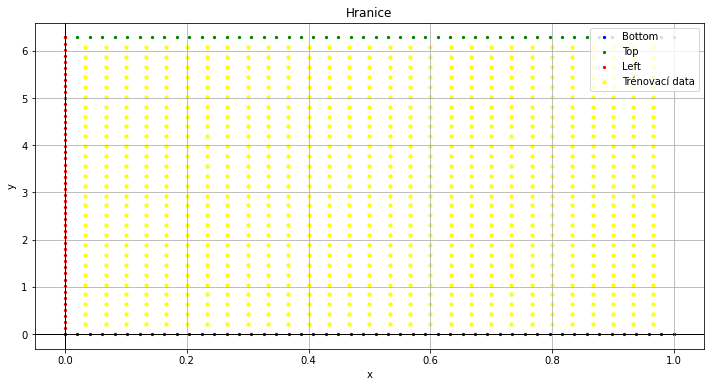

In [276]:
# Krok 3.1: Vygenerování trénovacích dat
t_train, x_train = generate_inner_train_data(1000) # Body uvnitř oblasti
t_bottom, x_bottom, t_top, x_top, t_left, x_left = generate_boundaries(50) # Body na hranici oblasti

plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left) # Vykreslení trénovacích dat

In [277]:
# Krok 3.2: Inicializace modelu a optimalizátoru
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=5e-3) 

In [278]:
# Krok 4.1: Trénovací smyčka
loss_values = [] # Seznam pro ukládání ztráty v každé epoše
epochs = 5000
best_loss = float('inf')
best_epoch = -1 
best_model_state_dict = None
for epoch in range(epochs):
    if epoch <= epochs-100:
        optimizer.zero_grad()
    
        # Výpočet ztráty
        loss = compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

        loss.backward() # Backward pass
        optimizer.step() # Optimalizace
    else:
        loss = optimizer.step(closure)

    if epoch == epochs-100:
        print(f"Změna optimalizátoru v epoše {epoch + 1}. Použití NN s nejlepší ztrátou {best_loss:.6f}")
        model.load_state_dict(best_model_state_dict)
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=10)

    loss_values.append(loss.detach().numpy())

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        best_model_state_dict = model.state_dict()

    if (epoch + 1) % 100 == 0:
        print(f'Epocha {epoch+1}/{epochs}, Ztráta: {loss.item()}')

Epocha 100/5000, Ztráta: 0.04465918242931366
Epocha 200/5000, Ztráta: 0.0040961080230772495
Epocha 300/5000, Ztráta: 0.001970764482393861
Epocha 400/5000, Ztráta: 0.01993730664253235
Epocha 500/5000, Ztráta: 0.07179350405931473
Epocha 600/5000, Ztráta: 0.0019350541988387704
Epocha 700/5000, Ztráta: 0.01063453871756792
Epocha 800/5000, Ztráta: 0.013217218220233917
Epocha 900/5000, Ztráta: 0.0041310833767056465
Epocha 1000/5000, Ztráta: 0.0038364664651453495
Epocha 1100/5000, Ztráta: 0.0014915727078914642
Epocha 1200/5000, Ztráta: 0.0054344250820577145
Epocha 1300/5000, Ztráta: 0.001958924811333418
Epocha 1400/5000, Ztráta: 0.0016839276067912579
Epocha 1500/5000, Ztráta: 0.0020656073465943336
Epocha 1600/5000, Ztráta: 0.04656143859028816
Epocha 1700/5000, Ztráta: 0.009066009894013405
Epocha 1800/5000, Ztráta: 0.006730305030941963
Epocha 1900/5000, Ztráta: 0.0014926944859325886
Epocha 2000/5000, Ztráta: 0.002324174391105771
Epocha 2100/5000, Ztráta: 0.002471247687935829
Epocha 2200/5000, 

Nejlepší epocha 4960, Ztráta: 2.4663859221618623e-05


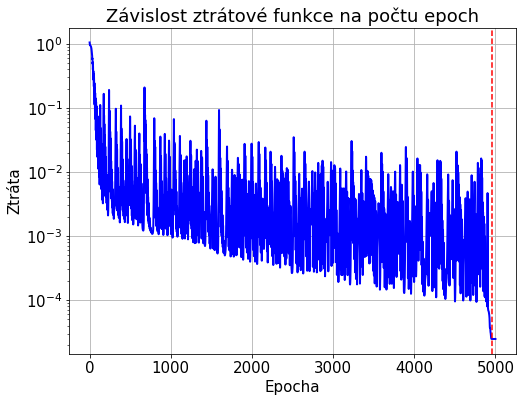

In [279]:
# Krok 4.2: Graf znázorňující závislost ztráty na počtu epoch
best_epoch = min(loss_values)
best_epoch_idx = loss_values.index(best_epoch)
print(f'Nejlepší epocha {best_epoch_idx}, Ztráta: {best_epoch}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.axvline(best_epoch_idx, color='r', linestyle='--', label='Nejlepší epocha')
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch', fontsize=18)
plt.xlabel('Epocha', fontsize=15)
plt.ylabel('Ztráta', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

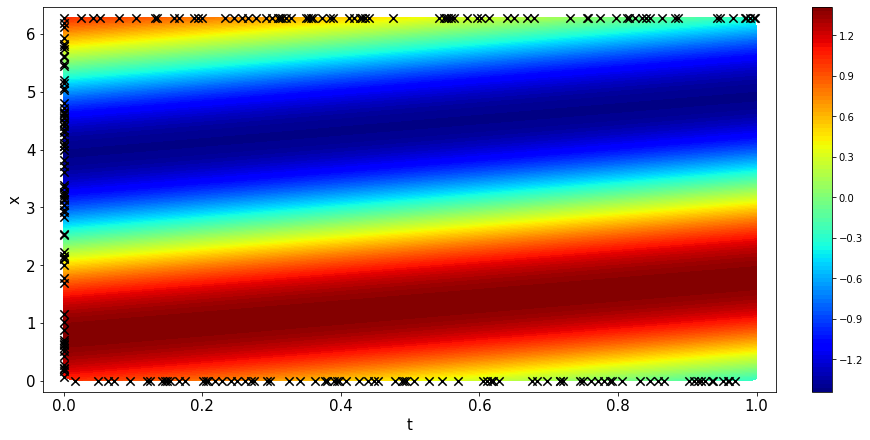

Testovací body na hranici (225)


In [280]:
# Krok 5.1: Vykreslení aproximace NN řešení zadané úlohy ve 2D grafu s interpolací
t_test, x_test = generate_test_data_lhs(10000)
model.load_state_dict(best_model_state_dict)
with torch.no_grad():
    inputs = torch.cat([t_test, x_test], dim=1)
    u_pred = model(inputs) 

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = u_pred.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)
# Vykreslení bodů na hranici
boundary_mask = (x == 0) | (x == 2*np.pi) | (t == 0)
t_boundary = t[boundary_mask]
x_boundary = x[boundary_mask]
no_bound_points = len(t_boundary)
ax.scatter(t_boundary, x_boundary, color="black", s=70, label=f"Testovací body na hranici ({no_bound_points})", marker="x")

#ax.legend(fontsize=15)
x_padding = 0.03 * (x_boundary.max() - x_boundary.min())  # Přidání okrajů
t_padding = 0.03 * (t_boundary.max() - t_boundary.min())
ax.set_xlim(t_boundary.min() - t_padding, t_boundary.max() + t_padding)
ax.set_ylim(x_boundary.min() - x_padding, x_boundary.max() + x_padding)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
print(f"Testovací body na hranici ({no_bound_points})")

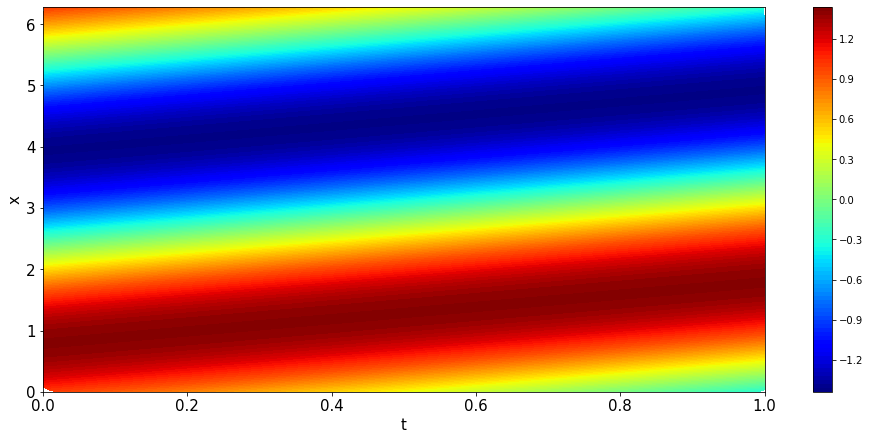

In [281]:
# Krok 5.2: Vykreslení přesného řešení
true_values = exact_solution(t_test, x_test)

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = true_values.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [282]:
# Krok 5.3: Definice funkce pro vykreslení řezů aproximace řešení pomocí NN a přesného řešení
def plot_solution_cut_with_exact(t_fixed, t_test, x_test, u_pred):
    t = t_test.detach().cpu().numpy().squeeze()
    x = x_test.detach().cpu().numpy().squeeze()
    z = u_pred.detach().cpu().numpy().squeeze()

    # Body poblíž řezu
    tolerance = 1e-3
    mask = np.abs(t - t_fixed) < tolerance
    x_filtered = x[mask]
    z_filtered = z[mask]

    # Interpolace
    x_interp = np.linspace(x_filtered.min(), x_filtered.max(), 500)
    z_interp = griddata(x_filtered, z_filtered, x_interp, method="cubic")

    # Přesné řešení
    t_fixed_tensor = torch.full((500, 1), t_fixed)
    x_interp_tensor = torch.tensor(x_interp, dtype=torch.float32).view(-1, 1)
    exact_z = exact_solution(t_fixed_tensor, x_interp_tensor)
    exact_z = exact_z.detach().cpu().numpy().squeeze()

    # Vykreslení predikcí a přesného řešení
    plt.figure(figsize=(12, 12))
    plt.plot(x_interp, exact_z, label="Analytické řešení", color="blue", linewidth=5)
    plt.plot(x_interp, z_interp, label=f"Predikce NN (t = {t_fixed:.3f})", color="red",linestyle="--", linewidth=5)
    plt.title(f"Řez v t = {t_fixed:.3f}", fontsize=18)
    plt.xlabel("x", fontsize=15)
    plt.ylabel("u", fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.grid()
    plt.show()

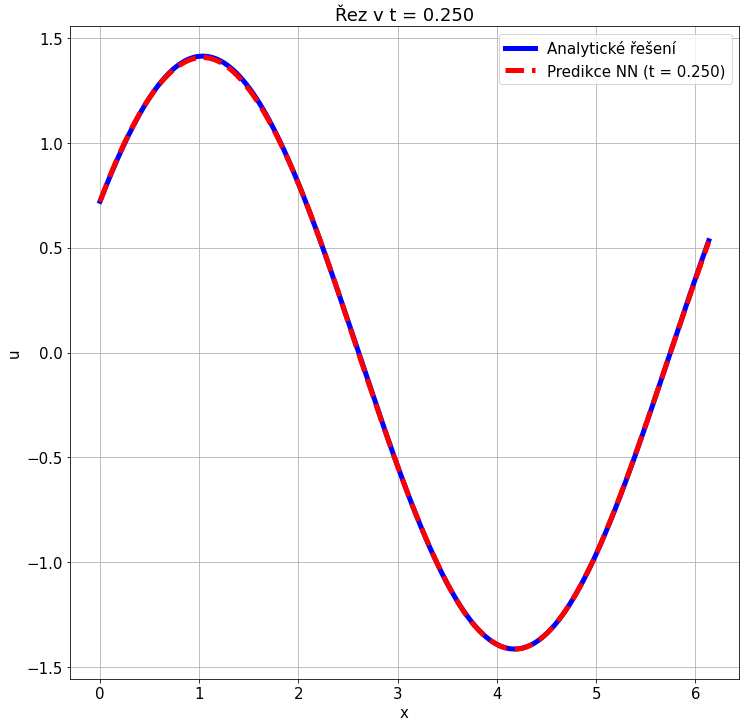

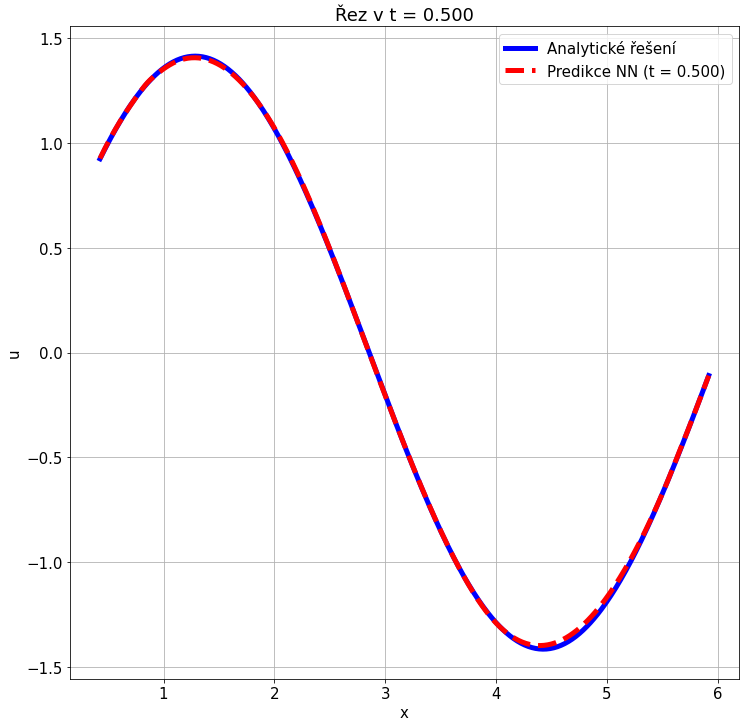

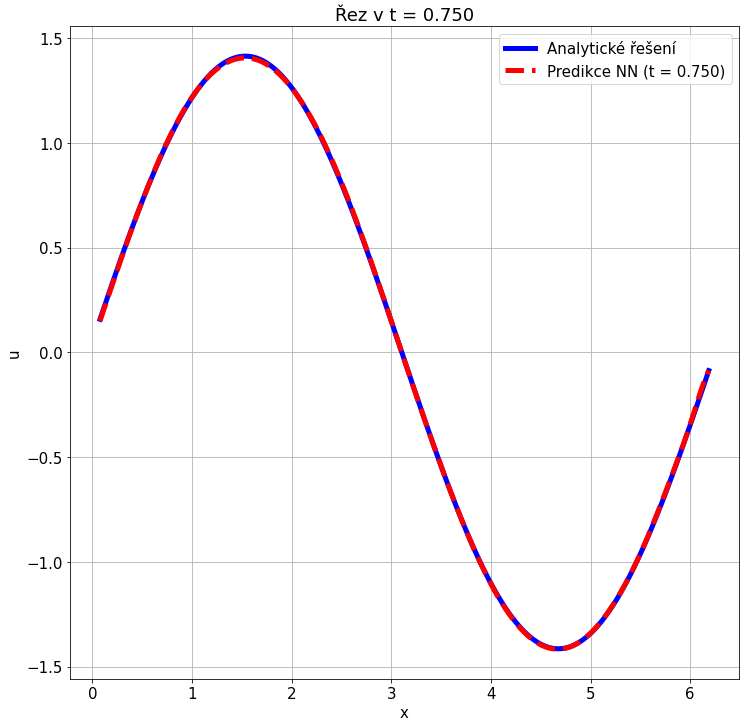

In [283]:
# Krok 5.4: Vykreslení řezů přesného a aproximovaného řešení v t=0,25; t=0,5; t=0,75
plot_solution_cut_with_exact(0.25, t_test, x_test, u_pred)
plot_solution_cut_with_exact(0.5, t_test, x_test, u_pred)
plot_solution_cut_with_exact(0.75, t_test, x_test, u_pred)

In [284]:
# Krok 6.1: Výpočet relativní a absolutní chyby aproximace řešení NN
true_values = exact_solution(t_test, x_test)

error_norm = torch.norm(u_pred - true_values)
true_norm = torch.norm(true_values)
relative_error = error_norm / true_norm
absolute_error = torch.norm(u_pred - true_values)
print(f'Relativní chyba aproximace: {relative_error.item():.6f}')
print(f'Absolutní chyba aproximace: {absolute_error.item():.6f}')

Relativní chyba aproximace: 0.003419
Absolutní chyba aproximace: 0.339673


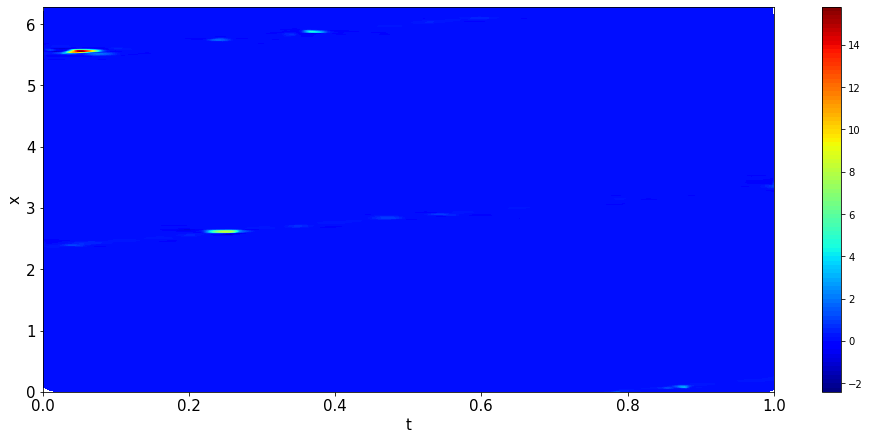

In [285]:
# Krok 6.2: Výpočet a vykreselní relativní pointwise chyby aproximace řešení NN
pointwise_relative_error = torch.abs((u_pred - true_values) / (true_values))

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = pointwise_relative_error.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [286]:
def plot_loss_landscape(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, perturb_scale=0.1, num_points=50):
    # Save original parameters
    original_params = [param.clone() for param in model.parameters()]
    
    # Generate grid of perturbations
    epsilon_1 = np.linspace(-perturb_scale, perturb_scale, num_points)
    epsilon_2 = np.linspace(-perturb_scale, perturb_scale, num_points)
    epsilon_1, epsilon_2 = np.meshgrid(epsilon_1, epsilon_2)
    
    # Prepare to store losses
    losses = np.zeros_like(epsilon_1)
    
    # Compute loss for each combination of (epsilon_1, epsilon_2)
    for i in range(num_points):
        for j in range(num_points):
            # Perturb parameters
            with torch.no_grad():
                for k, param in enumerate(model.parameters()):
                    param.add_(epsilon_1[i, j] + epsilon_2[i, j])
            
            # Compute loss
            losses[i, j] = compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left).item()
            
            # Reset parameters to original
            with torch.no_grad():
                for k, param in enumerate(model.parameters()):
                    param.copy_(original_params[k])
    
    # Plot the loss landscape
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(epsilon_1, epsilon_2, losses, cmap='coolwarm', edgecolor='k', alpha=0.8)
    ax.set_xlabel(r'$\epsilon_1$', fontsize=15)
    ax.set_ylabel(r'$\epsilon_2$', fontsize=15)
    ax.set_zlabel('Loss', fontsize=15)
    plt.title(rf'Loss Landscape for $\beta = {BETA}$', fontsize=18)
    plt.show()

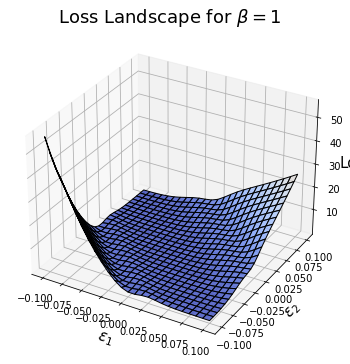

In [287]:
plot_loss_landscape(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, 0.1, 25)